In [1]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [4]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


In [5]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.228222107326
Count: 1204949


In [6]:
#downsample

df = pd.concat([df[df.is_blocked == 1].sample(125000), df[df.is_blocked == 0].sample(125000)])
#df = <downsampled dataset>

print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.5
Count: 250000


In [7]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [8]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


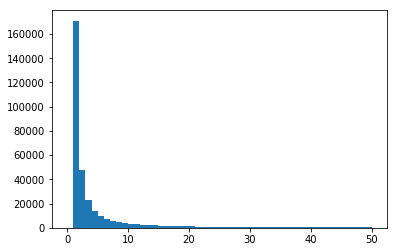

In [9]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [10]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
#tokens = <tokens from token_counts keys that had at least min_count occurences throughout the dataset>
tokens = [i for i in token_counts.keys() if token_counts[i] > min_count]

In [11]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [12]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 52616


In [13]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [14]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

In [15]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (250000, 15)
Антицеллюлитный массаж в краснодаре -> [ 2471 36647 43364 39692     0     0     0     0     0     0] ...
Психологическая консультация -> [47228 34364     0     0     0     0     0     0     0     0] ...
Ден, 25 -> [36658 35280     0     0     0     0     0     0     0     0] ...


In [16]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [23]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories = [{"category":category_name, "subcategory":subcategory_name} for (category_name, subcategory_name) in data_cat_subcat]
#categories = [A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

['\xd0\xa3\xd1\x81\xd0\xbb\xd1\x83\xd0\xb3\xd0\xb8'
 '\xd0\x9f\xd1\x80\xd0\xb5\xd0\xb4\xd0\xbb\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xb8\xd1\x8f \xd1\x83\xd1\x81\xd0\xbb\xd1\x83\xd0\xb3']
Услуги
Предложения услуг


In [24]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [25]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')
#Non-sequences
df_non_text = df_non_text.astype('float32')

In [26]:
from sklearn.cross_validation import train_test_split
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard


title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(title_tokens, desc_tokens, df_non_text, target)
#title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = <define_these_variables>

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [3]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    data_tuple = (title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts)
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Reading saved data...
done


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [4]:
#libraries
import lasagne
from theano import tensor as T
import theano

In [5]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [6]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [7]:
# Descriptions
descr_output_sz = 64
title_output_sz = 64
cat_output_sz = 64
#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=descr_output_sz)
#descr_nn = RNN or LSTM over embedding, maybe several ones in a stack
descr_nn = lasagne.layers.LSTMLayer(descr_nn, descr_output_sz, nonlinearity=lasagne.nonlinearities.tanh)
descr_sp = descr_nn.output_shape
descr_nn = lasagne.layers.ReshapeLayer(descr_nn, ([0],descr_sp[1]*descr_sp[2]))

# Titles
#title_nn = <Process titles somehow (title_inp)>
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=title_output_sz)
title_nn = lasagne.layers.LSTMLayer(title_nn, title_output_sz, nonlinearity=lasagne.nonlinearities.tanh)
title_sp = title_nn.output_shape
title_nn = lasagne.layers.ReshapeLayer(title_nn, ([0],title_sp[1]*title_sp[2]))

# Non-sequences
#cat_nn = <Process non-sequences(cat_inp)>
cat_nn = lasagne.layers.DenseLayer(cat_inp, cat_output_sz, W = lasagne.init.Normal(), nonlinearity=lasagne.nonlinearities.tanh)


In [8]:
your_lucky_number = 13
maybe_use_me = 0.1
#nn = <merge three layers into one (e.g. lasagne.layers.concat) >                                  
nn = lasagne.layers.concat([descr_nn, title_nn, cat_nn]) 
nn = lasagne.layers.DenseLayer(nn,your_lucky_number)
nn = lasagne.layers.DropoutLayer(nn,p=maybe_use_me)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [9]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [12]:
what_do_you_think = 1
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
#loss = lasagne.objectives.binary_hinge_loss(prediction, target_y,delta = what_do_you_think).mean()
loss = lasagne.objectives.binary_hinge_loss(prediction, target_y,delta = what_do_you_think, log_odds=True).mean()

In [13]:
#Weight optimization step
#updates = <your favorite optimizer>
updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=0.01, momentum=0.9)

In [15]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
#det_loss = <an excercise in copy-pasting and editing>
det_loss = lasagne.objectives.binary_hinge_loss(prediction, target_y,delta = what_do_you_think, log_odds=True).mean()

### Coffee-lation

In [16]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

/usr/local/lib/python2.7/dist-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [18]:
#average precision at K

from oracle import APatK, score

In [19]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 5000
batch_size = 15
minibatches_per_epoch = 15

for i in range(n_epochs):
    #training
    print "epoch =", i
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr.values,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr.values,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

epoch = 0
Train:
	loss: 0.269390324471
	acc: 0.883333333333
	auc: 0.931557747066
	ap@k: 1.0
Val:
	loss: 0.27511728423
	acc: 0.870833333333
	auc: 0.945731026786
	ap@k: 1.0
epoch = 1
Train:
	loss: 0.220204779187
	acc: 0.904166666667
	auc: 0.953455228031
	ap@k: 1.0
Val:
	loss: 0.295184070468
	acc: 0.879166666667
	auc: 0.947745118477
	ap@k: 1.0
epoch = 2
Train:
	loss: 0.284930501297
	acc: 0.875
	auc: 0.940483635606
	ap@k: 1.0
Val:
	loss: 0.319266287825
	acc: 0.879166666667
	auc: 0.934160839161
	ap@k: 1.0
epoch = 3
Train:
	loss: 0.242844391467
	acc: 0.891666666667
	auc: 0.959441627891
	ap@k: 1.0
Val:
	loss: 0.292554449042
	acc: 0.879166666667
	auc: 0.936874304783
	ap@k: 1.0
epoch = 4
Train:
	loss: 0.235386352743
	acc: 0.9
	auc: 0.934634620728
	ap@k: 1.0
Val:
	loss: 0.306210754707
	acc: 0.8625
	auc: 0.924703054299
	ap@k: 1.0
epoch = 5
Train:
	loss: 0.242301154476
	acc: 0.891666666667
	auc: 0.942053670745
	ap@k: 1.0
Val:
	loss: 0.252323525978
	acc: 0.883333333333
	auc: 0.939670741873
	ap@k: 1

Train:
	loss: 0.167969168832
	acc: 0.929166666667
	auc: 0.961422247207
	ap@k: 1.0
Val:
	loss: 0.21490856138
	acc: 0.9
	auc: 0.924578095701
	ap@k: 1.0
epoch = 51
Train:
	loss: 0.244223509325
	acc: 0.891666666667
	auc: 0.953787667411
	ap@k: 1.0
Val:
	loss: 0.241913956307
	acc: 0.908333333333
	auc: 0.95794523426
	ap@k: 1.0
epoch = 52
Train:
	loss: 0.18817940277
	acc: 0.929166666667
	auc: 0.950212528744
	ap@k: 1.0
Val:
	loss: 0.243031526625
	acc: 0.904166666667
	auc: 0.946188811189
	ap@k: 1.0
epoch = 53
Train:
	loss: 0.28263281805
	acc: 0.870833333333
	auc: 0.93052074631
	ap@k: 1.0
Val:
	loss: 0.334398699661
	acc: 0.845833333333
	auc: 0.942539130435
	ap@k: 1.0
epoch = 54
Train:
	loss: 0.203315603682
	acc: 0.904166666667
	auc: 0.952208695652
	ap@k: 1.0
Val:
	loss: 0.237558650975
	acc: 0.879166666667
	auc: 0.946138711264
	ap@k: 1.0
epoch = 55
Train:
	loss: 0.190213180381
	acc: 0.904166666667
	auc: 0.966226086957
	ap@k: 1.0
Val:
	loss: 0.220255094172
	acc: 0.908333333333
	auc: 0.969382716049


Train:
	loss: 0.240577282208
	acc: 0.895833333333
	auc: 0.941836238628
	ap@k: 1.0
Val:
	loss: 0.219078545473
	acc: 0.891666666667
	auc: 0.951738946776
	ap@k: 1.0
epoch = 100
Train:
	loss: 0.235449292623
	acc: 0.904166666667
	auc: 0.935464668394
	ap@k: 0.955782312925
Val:
	loss: 0.280843876536
	acc: 0.879166666667
	auc: 0.920293381535
	ap@k: 1.0
epoch = 101
Train:
	loss: 0.189488620951
	acc: 0.925
	auc: 0.962986111111
	ap@k: 1.0
Val:
	loss: 0.229112250628
	acc: 0.9
	auc: 0.931919642857
	ap@k: 1.0
epoch = 102
Train:
	loss: 0.200221803349
	acc: 0.916666666667
	auc: 0.947044933676
	ap@k: 1.0
Val:
	loss: 0.325354269255
	acc: 0.8625
	auc: 0.949898961745
	ap@k: 1.0
epoch = 103
Train:
	loss: 0.193740506418
	acc: 0.916666666667
	auc: 0.965681834019
	ap@k: 1.0
Val:
	loss: 0.2242786263
	acc: 0.908333333333
	auc: 0.97083130773
	ap@k: 1.0
epoch = 104
Train:
	loss: 0.23727233314
	acc: 0.904166666667
	auc: 0.956376771325
	ap@k: 1.0
Val:
	loss: 0.228830820075
	acc: 0.9125
	auc: 0.959155320922
	ap@k: 1

Train:
	loss: 0.151042454128
	acc: 0.933333333333
	auc: 0.949273851713
	ap@k: 1.0
Val:
	loss: 0.216103464619
	acc: 0.920833333333
	auc: 0.960556521739
	ap@k: 1.0
epoch = 149
Train:
	loss: 0.15326908194
	acc: 0.929166666667
	auc: 0.954680429864
	ap@k: 1.0
Val:
	loss: 0.292531298958
	acc: 0.895833333333
	auc: 0.893048128342
	ap@k: 0.772448979592
epoch = 150
Train:
	loss: 0.249712530449
	acc: 0.883333333333
	auc: 0.898844333055
	ap@k: 1.0
Val:
	loss: 0.239968797934
	acc: 0.8875
	auc: 0.928125
	ap@k: 1.0
epoch = 151
Train:
	loss: 0.321328455375
	acc: 0.858333333333
	auc: 0.899652173913
	ap@k: 1.0
Val:
	loss: 0.145678531408
	acc: 0.933333333333
	auc: 0.973808695652
	ap@k: 1.0
epoch = 152
Train:
	loss: 0.135168635932
	acc: 0.9375
	auc: 0.9584
	ap@k: 1.0
Val:
	loss: 0.34196191736
	acc: 0.833333333333
	auc: 0.91582748802
	ap@k: 1.0
epoch = 153
Train:
	loss: 0.230703066913
	acc: 0.9
	auc: 0.933356643357
	ap@k: 1.0
Val:
	loss: 0.226915579266
	acc: 0.908333333333
	auc: 0.936279619206
	ap@k: 1.0
e

Train:
	loss: 0.152350748972
	acc: 0.929166666667
	auc: 0.948321678322
	ap@k: 1.0
Val:
	loss: 0.211896502886
	acc: 0.916666666667
	auc: 0.957786116323
	ap@k: 1.0
epoch = 198
Train:
	loss: 0.17052471016
	acc: 0.920833333333
	auc: 0.96313700919
	ap@k: 1.0
Val:
	loss: 0.261411980055
	acc: 0.8875
	auc: 0.946259733037
	ap@k: 0.891496598639
epoch = 199
Train:
	loss: 0.172938017288
	acc: 0.908333333333
	auc: 0.950698353137
	ap@k: 1.0
Val:
	loss: 0.230241525313
	acc: 0.904166666667
	auc: 0.937078963817
	ap@k: 1.0
epoch = 200
Train:
	loss: 0.137178299581
	acc: 0.933333333333
	auc: 0.955717371612
	ap@k: 1.0
Val:
	loss: 0.209071361786
	acc: 0.9125
	auc: 0.957602339181
	ap@k: 1.0
epoch = 201
Train:
	loss: 0.200464454881
	acc: 0.9125
	auc: 0.942148760331
	ap@k: 1.0
Val:
	loss: 0.256252839534
	acc: 0.908333333333
	auc: 0.949437809903
	ap@k: 0.979591836735
epoch = 202
Train:
	loss: 0.208566132279
	acc: 0.9125
	auc: 0.957915622389
	ap@k: 1.0
Val:
	loss: 0.210883872821
	acc: 0.916666666667
	auc: 0.9614

Train:
	loss: 0.224872946069
	acc: 0.904166666667
	auc: 0.926576826896
	ap@k: 1.0
Val:
	loss: 0.256261757956
	acc: 0.879166666667
	auc: 0.934638701136
	ap@k: 1.0
epoch = 247
Train:
	loss: 0.169230012265
	acc: 0.916666666667
	auc: 0.961879185268
	ap@k: 1.0
Val:
	loss: 0.271873303056
	acc: 0.920833333333
	auc: 0.962893344472
	ap@k: 1.0
epoch = 248
Train:
	loss: 0.241722747788
	acc: 0.8875
	auc: 0.940344659857
	ap@k: 1.0
Val:
	loss: 0.24785385621
	acc: 0.895833333333
	auc: 0.944347826087
	ap@k: 1.0
epoch = 249
Train:
	loss: 0.233762389013
	acc: 0.904166666667
	auc: 0.907770079186
	ap@k: 0.955782312925
Val:
	loss: 0.23659566618
	acc: 0.904166666667
	auc: 0.941975137162
	ap@k: 1.0
epoch = 250
Train:
	loss: 0.205093359321
	acc: 0.908333333333
	auc: 0.960292875246
	ap@k: 1.0
Val:
	loss: 0.225948028993
	acc: 0.895833333333
	auc: 0.938819444444
	ap@k: 1.0
epoch = 251
Train:
	loss: 0.210697150229
	acc: 0.9125
	auc: 0.939652173913
	ap@k: 1.0
Val:
	loss: 0.158861436877
	acc: 0.9375
	auc: 0.9710336

Train:
	loss: 0.210819765427
	acc: 0.9125
	auc: 0.950699300699
	ap@k: 1.0
Val:
	loss: 0.220200748361
	acc: 0.908333333333
	auc: 0.963739927758
	ap@k: 1.0
epoch = 296
Train:
	loss: 0.156846505936
	acc: 0.9375
	auc: 0.97048951049
	ap@k: 1.0
Val:
	loss: 0.216359173719
	acc: 0.920833333333
	auc: 0.955138888889
	ap@k: 1.0
epoch = 297
Train:
	loss: 0.132968131646
	acc: 0.9375
	auc: 0.958286830357
	ap@k: 1.0
Val:
	loss: 0.200376156783
	acc: 0.9125
	auc: 0.959302729356
	ap@k: 1.0
epoch = 298
Train:
	loss: 0.187710460679
	acc: 0.916666666667
	auc: 0.961664004445
	ap@k: 1.0
Val:
	loss: 0.242969070512
	acc: 0.9
	auc: 0.932896205357
	ap@k: 1.0
epoch = 299
Train:
	loss: 0.259249027554
	acc: 0.879166666667
	auc: 0.914314727922
	ap@k: 1.0
Val:
	loss: 0.205196122278
	acc: 0.904166666667
	auc: 0.94864469375
	ap@k: 1.0
epoch = 300
Train:
	loss: 0.1368976211
	acc: 0.945833333333
	auc: 0.982905982906
	ap@k: 1.0
Val:
	loss: 0.208436913228
	acc: 0.920833333333
	auc: 0.974287506097
	ap@k: 1.0
epoch = 301
Tra

Train:
	loss: 0.226885304878
	acc: 0.908333333333
	auc: 0.955949296169
	ap@k: 1.0
Val:
	loss: 0.287090169276
	acc: 0.870833333333
	auc: 0.912318789831
	ap@k: 1.0
epoch = 345
Train:
	loss: 0.185081325208
	acc: 0.9125
	auc: 0.948551935394
	ap@k: 1.0
Val:
	loss: 0.193718018148
	acc: 0.908333333333
	auc: 0.956034782609
	ap@k: 1.0
epoch = 346
Train:
	loss: 0.148632689575
	acc: 0.941666666667
	auc: 0.979299805502
	ap@k: 1.0
Val:
	loss: 0.294926195821
	acc: 0.9
	auc: 0.959703889936
	ap@k: 1.0
epoch = 347
Train:
	loss: 0.273648105447
	acc: 0.895833333333
	auc: 0.920793110633
	ap@k: 1.0
Val:
	loss: 0.264854194707
	acc: 0.870833333333
	auc: 0.925797890914
	ap@k: 1.0
epoch = 348
Train:
	loss: 0.161654401235
	acc: 0.941666666667
	auc: 0.980979020979
	ap@k: 1.0
Val:
	loss: 0.24914562091
	acc: 0.883333333333
	auc: 0.945008342603
	ap@k: 1.0
epoch = 349
Train:
	loss: 0.203564428884
	acc: 0.916666666667
	auc: 0.948891668404
	ap@k: 1.0
Val:
	loss: 0.174637068369
	acc: 0.933333333333
	auc: 0.961187373702

Train:
	loss: 0.152493916546
	acc: 0.920833333333
	auc: 0.974636925856
	ap@k: 1.0
Val:
	loss: 0.269209486092
	acc: 0.875
	auc: 0.946498325893
	ap@k: 1.0
epoch = 394
Train:
	loss: 0.183695445187
	acc: 0.9125
	auc: 0.95193109197
	ap@k: 1.0
Val:
	loss: 0.225242141049
	acc: 0.908333333333
	auc: 0.954989873595
	ap@k: 1.0
epoch = 395
Train:
	loss: 0.223079984158
	acc: 0.904166666667
	auc: 0.945783550986
	ap@k: 1.0
Val:
	loss: 0.211656627056
	acc: 0.920833333333
	auc: 0.976935405198
	ap@k: 1.0
epoch = 396
Train:
	loss: 0.208147829331
	acc: 0.916666666667
	auc: 0.954659598214
	ap@k: 1.0
Val:
	loss: 0.247417359506
	acc: 0.895833333333
	auc: 0.931913116124
	ap@k: 1.0
epoch = 397
Train:
	loss: 0.2083466071
	acc: 0.904166666667
	auc: 0.952524038462
	ap@k: 1.0
Val:
	loss: 0.161728730394
	acc: 0.929166666667
	auc: 0.967514418734
	ap@k: 1.0
epoch = 398
Train:
	loss: 0.237713682761
	acc: 0.9
	auc: 0.929505005562
	ap@k: 0.955782312925
Val:
	loss: 0.17816991235
	acc: 0.916666666667
	auc: 0.978111888112


Train:
	loss: 0.158138470015
	acc: 0.920833333333
	auc: 0.934245335561
	ap@k: 1.0
Val:
	loss: 0.228496631131
	acc: 0.9125
	auc: 0.951022415853
	ap@k: 1.0
epoch = 443
Train:
	loss: 0.210634211996
	acc: 0.920833333333
	auc: 0.945991942206
	ap@k: 1.0
Val:
	loss: 0.205748292894
	acc: 0.908333333333
	auc: 0.961763070078
	ap@k: 1.0
epoch = 444
Train:
	loss: 0.144600750858
	acc: 0.941666666667
	auc: 0.976304634841
	ap@k: 1.0
Val:
	loss: 0.193814286006
	acc: 0.908333333333
	auc: 0.95646584671
	ap@k: 1.0
epoch = 445
Train:
	loss: 0.144276363232
	acc: 0.945833333333
	auc: 0.978321678322
	ap@k: 1.0
Val:
	loss: 0.248231552271
	acc: 0.908333333333
	auc: 0.956639566396
	ap@k: 1.0
epoch = 446
Train:
	loss: 0.190992272531
	acc: 0.9125
	auc: 0.960821286403
	ap@k: 1.0
Val:
	loss: 0.236065038949
	acc: 0.904166666667
	auc: 0.957729468599
	ap@k: 1.0
epoch = 447
Train:
	loss: 0.189548474201
	acc: 0.925
	auc: 0.963983050847
	ap@k: 1.0
Val:
	loss: 0.189901948069
	acc: 0.925
	auc: 0.966907675195
	ap@k: 1.0
epo

Val:
	loss: 0.119890543808
	acc: 0.958333333333
	auc: 0.980578139115
	ap@k: 1.0
epoch = 492
Train:
	loss: 0.102105102251
	acc: 0.958333333333
	auc: 0.972075576549
	ap@k: 1.0
Val:
	loss: 0.175349737714
	acc: 0.925
	auc: 0.954305555556
	ap@k: 1.0
epoch = 493
Train:
	loss: 0.160255594383
	acc: 0.945833333333
	auc: 0.959806397306
	ap@k: 1.0
Val:
	loss: 0.249535966842
	acc: 0.8875
	auc: 0.934403446599
	ap@k: 1.0
epoch = 494
Train:
	loss: 0.232802331388
	acc: 0.891666666667
	auc: 0.944653956282
	ap@k: 1.0
Val:
	loss: 0.221995229493
	acc: 0.916666666667
	auc: 0.942464040025
	ap@k: 1.0
epoch = 495
Train:
	loss: 0.0692890058053
	acc: 0.970833333333
	auc: 0.99658203125
	ap@k: 1.0
Val:
	loss: 0.237277918814
	acc: 0.895833333333
	auc: 0.941497497219
	ap@k: 1.0
epoch = 496
Train:
	loss: 0.193132273071
	acc: 0.920833333333
	auc: 0.954010173507
	ap@k: 1.0
Val:
	loss: 0.141638582234
	acc: 0.945833333333
	auc: 0.973053684284
	ap@k: 1.0
epoch = 497
Train:
	loss: 0.186549546614
	acc: 0.916666666667
	auc:

Val:
	loss: 0.167464064028
	acc: 0.916666666667
	auc: 0.979741019215
	ap@k: 1.0
epoch = 541
Train:
	loss: 0.118574960747
	acc: 0.954166666667
	auc: 0.979095652174
	ap@k: 1.0
Val:
	loss: 0.172731342601
	acc: 0.925
	auc: 0.961172135706
	ap@k: 1.0
epoch = 542
Train:
	loss: 0.146412767365
	acc: 0.9375
	auc: 0.970696607341
	ap@k: 1.0
Val:
	loss: 0.250730622772
	acc: 0.895833333333
	auc: 0.934071289334
	ap@k: 1.0
epoch = 543
Train:
	loss: 0.15167108853
	acc: 0.945833333333
	auc: 0.970383759733
	ap@k: 1.0
Val:
	loss: 0.185222586513
	acc: 0.920833333333
	auc: 0.958715277778
	ap@k: 1.0
epoch = 544
Train:
	loss: 0.165500350742
	acc: 0.925
	auc: 0.965198666296
	ap@k: 1.0
Val:
	loss: 0.188741535387
	acc: 0.920833333333
	auc: 0.95453593128
	ap@k: 1.0
epoch = 545
Train:
	loss: 0.0966800188273
	acc: 0.95
	auc: 0.979061045906
	ap@k: 1.0
Val:
	loss: 0.221979270267
	acc: 0.9125
	auc: 0.956307307585
	ap@k: 1.0
epoch = 546
Train:
	loss: 0.132445203557
	acc: 0.933333333333
	auc: 0.963782207098
	ap@k: 1.0
V

Train:
	loss: 0.113761328359
	acc: 0.945833333333
	auc: 0.959503615128
	ap@k: 1.0
Val:
	loss: 0.191374187586
	acc: 0.925
	auc: 0.946216385241
	ap@k: 1.0
epoch = 590
Train:
	loss: 0.149120843648
	acc: 0.941666666667
	auc: 0.957323865219
	ap@k: 1.0
Val:
	loss: 0.250268016197
	acc: 0.879166666667
	auc: 0.92485589277
	ap@k: 1.0
epoch = 591
Train:
	loss: 0.205165264807
	acc: 0.9125
	auc: 0.948815889992
	ap@k: 1.0
Val:
	loss: 0.157166595966
	acc: 0.933333333333
	auc: 0.959913401774
	ap@k: 1.0
epoch = 592
Train:
	loss: 0.156693518534
	acc: 0.925
	auc: 0.966889027865
	ap@k: 1.0
Val:
	loss: 0.180239170408
	acc: 0.9375
	auc: 0.973748176957
	ap@k: 1.0
epoch = 593
Train:
	loss: 0.175614278983
	acc: 0.929166666667
	auc: 0.961500974659
	ap@k: 1.0
Val:
	loss: 0.194480040496
	acc: 0.920833333333
	auc: 0.959696057147
	ap@k: 1.0
epoch = 594
Train:
	loss: 0.149213046623
	acc: 0.9375
	auc: 0.966552734375
	ap@k: 1.0
Val:
	loss: 0.202615960497
	acc: 0.9
	auc: 0.950065976804
	ap@k: 1.0
epoch = 595
Train:
	lo

Val:
	loss: 0.216868335156
	acc: 0.904166666667
	auc: 0.960352733686
	ap@k: 1.0
epoch = 639
Train:
	loss: 0.134050976366
	acc: 0.9375
	auc: 0.952741350446
	ap@k: 1.0
Val:
	loss: 0.215007720623
	acc: 0.933333333333
	auc: 0.969713809391
	ap@k: 1.0
epoch = 640
Train:
	loss: 0.141768403843
	acc: 0.9375
	auc: 0.989020979021
	ap@k: 1.0
Val:
	loss: 0.213995999543
	acc: 0.904166666667
	auc: 0.942116600653
	ap@k: 1.0
epoch = 641
Train:
	loss: 0.106285990579
	acc: 0.954166666667
	auc: 0.977692307692
	ap@k: 1.0
Val:
	loss: 0.1562563563
	acc: 0.9375
	auc: 0.978601398601
	ap@k: 1.0
epoch = 642
Train:
	loss: 0.19217840356
	acc: 0.908333333333
	auc: 0.968104347826
	ap@k: 1.0
Val:
	loss: 0.138557100559
	acc: 0.945833333333
	auc: 0.971857410882
	ap@k: 1.0
epoch = 643
Train:
	loss: 0.192352405474
	acc: 0.904166666667
	auc: 0.956573677184
	ap@k: 1.0
Val:
	loss: 0.133465746701
	acc: 0.945833333333
	auc: 0.970036931224
	ap@k: 1.0
epoch = 644
Train:
	loss: 0.186534166027
	acc: 0.916666666667
	auc: 0.9532163

Val:
	loss: 0.142136573309
	acc: 0.9375
	auc: 0.968122209821
	ap@k: 1.0
epoch = 688
Train:
	loss: 0.145120027542
	acc: 0.9375
	auc: 0.985901798736
	ap@k: 1.0
Val:
	loss: 0.180759169572
	acc: 0.916666666667
	auc: 0.980628527629
	ap@k: 1.0
epoch = 689
Train:
	loss: 0.165295159323
	acc: 0.920833333333
	auc: 0.969019171992
	ap@k: 1.0
Val:
	loss: 0.184248143812
	acc: 0.925
	auc: 0.972028459821
	ap@k: 1.0
epoch = 690
Train:
	loss: 0.16217397677
	acc: 0.929166666667
	auc: 0.950507085301
	ap@k: 1.0
Val:
	loss: 0.145434488059
	acc: 0.9375
	auc: 0.964851347597
	ap@k: 1.0
epoch = 691
Train:
	loss: 0.206974471331
	acc: 0.929166666667
	auc: 0.951188811189
	ap@k: 1.0
Val:
	loss: 0.129805625217
	acc: 0.95
	auc: 0.974775276984
	ap@k: 1.0
epoch = 692
Train:
	loss: 0.122550357302
	acc: 0.9625
	auc: 0.974157854191
	ap@k: 0.891496598639
Val:
	loss: 0.163869190427
	acc: 0.933333333333
	auc: 0.975417277743
	ap@k: 1.0
epoch = 693
Train:
	loss: 0.174369361676
	acc: 0.925
	auc: 0.955890525146
	ap@k: 1.0
Val:
	

Val:
	loss: 0.102799908036
	acc: 0.9625
	auc: 0.982003348214
	ap@k: 1.0
epoch = 737
Train:
	loss: 0.159014083143
	acc: 0.941666666667
	auc: 0.963052989791
	ap@k: 1.0
Val:
	loss: 0.176357158882
	acc: 0.929166666667
	auc: 0.965502645503
	ap@k: 1.0
epoch = 738
Train:
	loss: 0.0911503312287
	acc: 0.9625
	auc: 0.983547826087
	ap@k: 1.0
Val:
	loss: 0.176162793054
	acc: 0.916666666667
	auc: 0.974784662406
	ap@k: 1.0
epoch = 739
Train:
	loss: 0.111735117165
	acc: 0.945833333333
	auc: 0.965502645503
	ap@k: 1.0
Val:
	loss: 0.180403386482
	acc: 0.929166666667
	auc: 0.951668910779
	ap@k: 1.0
epoch = 740
Train:
	loss: 0.183091661272
	acc: 0.925
	auc: 0.959437779018
	ap@k: 1.0
Val:
	loss: 0.207694010264
	acc: 0.891666666667
	auc: 0.955165692008
	ap@k: 1.0
epoch = 741
Train:
	loss: 0.187549485763
	acc: 0.925
	auc: 0.969652777778
	ap@k: 1.0
Val:
	loss: 0.19669404537
	acc: 0.933333333333
	auc: 0.968540736607
	ap@k: 1.0
epoch = 742
Train:
	loss: 0.13037979952
	acc: 0.9375
	auc: 0.963816931731
	ap@k: 1.0

Train:
	loss: 0.134815919592
	acc: 0.945833333333
	auc: 0.983837737994
	ap@k: 1.0
Val:
	loss: 0.199295362183
	acc: 0.920833333333
	auc: 0.981832210999
	ap@k: 1.0
epoch = 786
Train:
	loss: 0.175435604727
	acc: 0.929166666667
	auc: 0.967798552905
	ap@k: 1.0
Val:
	loss: 0.268281047063
	acc: 0.879166666667
	auc: 0.930616357446
	ap@k: 1.0
epoch = 787
Train:
	loss: 0.197324364503
	acc: 0.904166666667
	auc: 0.959627544993
	ap@k: 1.0
Val:
	loss: 0.11262073536
	acc: 0.954166666667
	auc: 0.98701026608
	ap@k: 1.0
epoch = 788
Train:
	loss: 0.114606449078
	acc: 0.958333333333
	auc: 0.971287477954
	ap@k: 1.0
Val:
	loss: 0.108490101568
	acc: 0.95
	auc: 0.984335038363
	ap@k: 1.0
epoch = 789
Train:
	loss: 0.120158746506
	acc: 0.945833333333
	auc: 0.968855218855
	ap@k: 1.0
Val:
	loss: 0.194694683166
	acc: 0.908333333333
	auc: 0.947111238862
	ap@k: 1.0
epoch = 790
Train:
	loss: 0.151271113301
	acc: 0.929166666667
	auc: 0.975241336204
	ap@k: 1.0
Val:
	loss: 0.162115065354
	acc: 0.9375
	auc: 0.968576195773

Val:
	loss: 0.228543626655
	acc: 0.904166666667
	auc: 0.97348699095
	ap@k: 1.0
epoch = 834
Train:
	loss: 0.119080267317
	acc: 0.95
	auc: 0.965228903909
	ap@k: 1.0
Val:
	loss: 0.190221981343
	acc: 0.920833333333
	auc: 0.954128440367
	ap@k: 1.0
epoch = 835
Train:
	loss: 0.185725167562
	acc: 0.9125
	auc: 0.947826086957
	ap@k: 1.0
Val:
	loss: 0.191715734528
	acc: 0.920833333333
	auc: 0.959269565217
	ap@k: 1.0
epoch = 836
Train:
	loss: 0.147901833103
	acc: 0.929166666667
	auc: 0.984619140625
	ap@k: 1.0
Val:
	loss: 0.141100910811
	acc: 0.929166666667
	auc: 0.984782155514
	ap@k: 1.0
epoch = 837
Train:
	loss: 0.12929281391
	acc: 0.95
	auc: 0.966840326669
	ap@k: 1.0
Val:
	loss: 0.285859176647
	acc: 0.9
	auc: 0.967548500882
	ap@k: 1.0
epoch = 838
Train:
	loss: 0.196211984574
	acc: 0.933333333333
	auc: 0.959676298972
	ap@k: 1.0
Val:
	loss: 0.169157279215
	acc: 0.933333333333
	auc: 0.977120535714
	ap@k: 1.0
epoch = 839
Train:
	loss: 0.124561247537
	acc: 0.945833333333
	auc: 0.969054580897
	ap@k: 1

Val:
	loss: 0.150121244381
	acc: 0.929166666667
	auc: 0.971162532138
	ap@k: 1.0
epoch = 883
Train:
	loss: 0.172305031606
	acc: 0.929166666667
	auc: 0.951236454571
	ap@k: 1.0
Val:
	loss: 0.172369896397
	acc: 0.929166666667
	auc: 0.980034782609
	ap@k: 1.0
epoch = 884
Train:
	loss: 0.132688411085
	acc: 0.958333333333
	auc: 0.980369675492
	ap@k: 1.0
Val:
	loss: 0.117239305952
	acc: 0.958333333333
	auc: 0.964156710197
	ap@k: 1.0
epoch = 885
Train:
	loss: 0.143548588002
	acc: 0.9375
	auc: 0.956034782609
	ap@k: 1.0
Val:
	loss: 0.214297616076
	acc: 0.9
	auc: 0.939149763823
	ap@k: 1.0
epoch = 886
Train:
	loss: 0.172300406234
	acc: 0.9375
	auc: 0.967653394483
	ap@k: 1.0
Val:
	loss: 0.138416209089
	acc: 0.9375
	auc: 0.981959121246
	ap@k: 1.0
epoch = 887
Train:
	loss: 0.165905375155
	acc: 0.925
	auc: 0.95537454748
	ap@k: 1.0
Val:
	loss: 0.121163437516
	acc: 0.95
	auc: 0.972969216872
	ap@k: 1.0
epoch = 888
Train:
	loss: 0.185673133595
	acc: 0.908333333333
	auc: 0.952053366688
	ap@k: 1.0
Val:
	loss:

Val:
	loss: 0.18989240535
	acc: 0.933333333333
	auc: 0.972324466977
	ap@k: 1.0
epoch = 932
Train:
	loss: 0.0791366213748
	acc: 0.958333333333
	auc: 0.984509585996
	ap@k: 1.0
Val:
	loss: 0.187244477037
	acc: 0.933333333333
	auc: 0.970691224876
	ap@k: 1.0
epoch = 933
Train:
	loss: 0.18684429233
	acc: 0.9125
	auc: 0.960677749361
	ap@k: 1.0
Val:
	loss: 0.178327651916
	acc: 0.925
	auc: 0.968383017164
	ap@k: 1.0
epoch = 934
Train:
	loss: 0.0757474702061
	acc: 0.966666666667
	auc: 0.992775771048
	ap@k: 1.0
Val:
	loss: 0.196186212596
	acc: 0.920833333333
	auc: 0.955304928989
	ap@k: 1.0
epoch = 935
Train:
	loss: 0.124682732012
	acc: 0.958333333333
	auc: 0.976109095982
	ap@k: 1.0
Val:
	loss: 0.180386379913
	acc: 0.933333333333
	auc: 0.96520979021
	ap@k: 1.0
epoch = 936
Train:
	loss: 0.12674262104
	acc: 0.945833333333
	auc: 0.979149262044
	ap@k: 1.0
Val:
	loss: 0.128063423543
	acc: 0.945833333333
	auc: 0.980294363839
	ap@k: 1.0
epoch = 937
Train:
	loss: 0.130431702655
	acc: 0.9625
	auc: 0.9714004

Train:
	loss: 0.181999077838
	acc: 0.916666666667
	auc: 0.95150862069
	ap@k: 1.0
Val:
	loss: 0.155026543084
	acc: 0.95
	auc: 0.978738383554
	ap@k: 1.0
epoch = 981
Train:
	loss: 0.124611808032
	acc: 0.945833333333
	auc: 0.973544973545
	ap@k: 1.0
Val:
	loss: 0.245177733436
	acc: 0.9125
	auc: 0.955238563699
	ap@k: 1.0
epoch = 982
Train:
	loss: 0.186778692145
	acc: 0.920833333333
	auc: 0.949128411695
	ap@k: 1.0
Val:
	loss: 0.106095954799
	acc: 0.958333333333
	auc: 0.986457392875
	ap@k: 1.0
epoch = 983
Train:
	loss: 0.0807878897069
	acc: 0.9625
	auc: 0.985804966518
	ap@k: 1.0
Val:
	loss: 0.213176273497
	acc: 0.929166666667
	auc: 0.965297154018
	ap@k: 1.0
epoch = 984
Train:
	loss: 0.161726170687
	acc: 0.95
	auc: 0.951858813701
	ap@k: 1.0
Val:
	loss: 0.196264021672
	acc: 0.908333333333
	auc: 0.955880301339
	ap@k: 1.0
epoch = 985
Train:
	loss: 0.185802961504
	acc: 0.9125
	auc: 0.943993055556
	ap@k: 1.0
Val:
	loss: 0.159151271274
	acc: 0.920833333333
	auc: 0.96344018437
	ap@k: 1.0
epoch = 986
T

Val:
	loss: 0.162502901457
	acc: 0.925
	auc: 0.9761208577
	ap@k: 1.0
epoch = 1029
Train:
	loss: 0.103315870709
	acc: 0.954166666667
	auc: 0.978506944444
	ap@k: 1.0
Val:
	loss: 0.167483959837
	acc: 0.9375
	auc: 0.979792348965
	ap@k: 1.0
epoch = 1030
Train:
	loss: 0.159481594532
	acc: 0.941666666667
	auc: 0.963292547275
	ap@k: 1.0
Val:
	loss: 0.20961901299
	acc: 0.9
	auc: 0.959210617747
	ap@k: 1.0
epoch = 1031
Train:
	loss: 0.128774475926
	acc: 0.941666666667
	auc: 0.947223959419
	ap@k: 1.0
Val:
	loss: 0.158956673533
	acc: 0.9375
	auc: 0.987364243943
	ap@k: 1.0
epoch = 1032
Train:
	loss: 0.130895127465
	acc: 0.941666666667
	auc: 0.961605402395
	ap@k: 1.0
Val:
	loss: 0.198198331048
	acc: 0.908333333333
	auc: 0.961048010592
	ap@k: 1.0
epoch = 1033
Train:
	loss: 0.133650992602
	acc: 0.945833333333
	auc: 0.977225167411
	ap@k: 1.0
Val:
	loss: 0.187939949882
	acc: 0.9375
	auc: 0.969966629588
	ap@k: 1.0
epoch = 1034
Train:
	loss: 0.187708988193
	acc: 0.925
	auc: 0.968852573504
	ap@k: 1.0
Val:
	

Train:
	loss: 0.1413276007
	acc: 0.929166666667
	auc: 0.951802208487
	ap@k: 1.0
Val:
	loss: 0.142512310433
	acc: 0.933333333333
	auc: 0.97266313933
	ap@k: 1.0
epoch = 1078
Train:
	loss: 0.129700848409
	acc: 0.945833333333
	auc: 0.963171818435
	ap@k: 1.0
Val:
	loss: 0.204186951924
	acc: 0.916666666667
	auc: 0.96558676307
	ap@k: 1.0
epoch = 1079
Train:
	loss: 0.11655322993
	acc: 0.958333333333
	auc: 0.980979020979
	ap@k: 1.0
Val:
	loss: 0.207611742521
	acc: 0.929166666667
	auc: 0.974338495729
	ap@k: 1.0
epoch = 1080
Train:
	loss: 0.150612039955
	acc: 0.9375
	auc: 0.961434229727
	ap@k: 1.0
Val:
	loss: 0.239598057487
	acc: 0.895833333333
	auc: 0.951091490545
	ap@k: 1.0
epoch = 1081
Train:
	loss: 0.121120311548
	acc: 0.95
	auc: 0.976003091842
	ap@k: 1.0
Val:
	loss: 0.149820134838
	acc: 0.9375
	auc: 0.977395833333
	ap@k: 1.0
epoch = 1082
Train:
	loss: 0.10175252067
	acc: 0.954166666667
	auc: 0.987079744373
	ap@k: 1.0
Val:
	loss: 0.18202671582
	acc: 0.925
	auc: 0.957140872465
	ap@k: 1.0
epoch

Val:
	loss: 0.111620158469
	acc: 0.954166666667
	auc: 0.996039191161
	ap@k: 1.0
epoch = 1126
Train:
	loss: 0.121385420818
	acc: 0.954166666667
	auc: 0.963513043478
	ap@k: 1.0
Val:
	loss: 0.204418234372
	acc: 0.920833333333
	auc: 0.960785694171
	ap@k: 1.0
epoch = 1127
Train:
	loss: 0.109464439428
	acc: 0.954166666667
	auc: 0.961457381772
	ap@k: 1.0
Val:
	loss: 0.181368625653
	acc: 0.920833333333
	auc: 0.961345939933
	ap@k: 1.0
epoch = 1128
Train:
	loss: 0.248411906234
	acc: 0.895833333333
	auc: 0.921572735526
	ap@k: 1.0
Val:
	loss: 0.189529070497
	acc: 0.920833333333
	auc: 0.953599275968
	ap@k: 1.0
epoch = 1129
Train:
	loss: 0.0971970547849
	acc: 0.9625
	auc: 0.977773913043
	ap@k: 1.0
Val:
	loss: 0.199862741562
	acc: 0.929166666667
	auc: 0.962097902098
	ap@k: 1.0
epoch = 1130
Train:
	loss: 0.116213886895
	acc: 0.95
	auc: 0.970138888889
	ap@k: 1.0
Val:
	loss: 0.155853096877
	acc: 0.9375
	auc: 0.960878326732
	ap@k: 1.0
epoch = 1131
Train:
	loss: 0.216555365465
	acc: 0.925
	auc: 0.94771976

Val:
	loss: 0.160065590184
	acc: 0.925
	auc: 0.957473420888
	ap@k: 1.0
epoch = 1175
Train:
	loss: 0.118913346277
	acc: 0.95
	auc: 0.973686040044
	ap@k: 1.0
Val:
	loss: 0.227306351276
	acc: 0.908333333333
	auc: 0.946847098214
	ap@k: 1.0
epoch = 1176
Train:
	loss: 0.102884635497
	acc: 0.954166666667
	auc: 0.973309483726
	ap@k: 1.0
Val:
	loss: 0.13501582857
	acc: 0.933333333333
	auc: 0.972243478261
	ap@k: 1.0
epoch = 1177
Train:
	loss: 0.139730218075
	acc: 0.945833333333
	auc: 0.982118055556
	ap@k: 1.0
Val:
	loss: 0.168781516346
	acc: 0.925
	auc: 0.9708599611
	ap@k: 1.0
epoch = 1178
Train:
	loss: 0.141067833679
	acc: 0.958333333333
	auc: 0.968678140896
	ap@k: 1.0
Val:
	loss: 0.201574860101
	acc: 0.925
	auc: 0.969656808036
	ap@k: 1.0
epoch = 1179
Train:
	loss: 0.181393474487
	acc: 0.9375
	auc: 0.963524130191
	ap@k: 1.0
Val:
	loss: 0.172438038802
	acc: 0.9375
	auc: 0.986936279619
	ap@k: 1.0
epoch = 1180
Train:
	loss: 0.148909252504
	acc: 0.9375
	auc: 0.969097608454
	ap@k: 1.0
Val:
	loss: 0.

Train:
	loss: 0.126746404777
	acc: 0.954166666667
	auc: 0.977870475113
	ap@k: 1.0
Val:
	loss: 0.155457149562
	acc: 0.920833333333
	auc: 0.968520204496
	ap@k: 1.0
epoch = 1224
Train:
	loss: 0.150527085655
	acc: 0.945833333333
	auc: 0.965934371524
	ap@k: 1.0
Val:
	loss: 0.161789795278
	acc: 0.929166666667
	auc: 0.968712898945
	ap@k: 1.0
epoch = 1225
Train:
	loss: 0.107331821399
	acc: 0.95
	auc: 0.967638888889
	ap@k: 1.0
Val:
	loss: 0.194307550723
	acc: 0.908333333333
	auc: 0.961363636364
	ap@k: 1.0
epoch = 1226
Train:
	loss: 0.137364293148
	acc: 0.95
	auc: 0.972152076319
	ap@k: 1.0
Val:
	loss: 0.142984323366
	acc: 0.941666666667
	auc: 0.978263888889
	ap@k: 1.0
epoch = 1227
Train:
	loss: 0.168150352788
	acc: 0.941666666667
	auc: 0.958191304348
	ap@k: 1.0
Val:
	loss: 0.153141121007
	acc: 0.929166666667
	auc: 0.974858183346
	ap@k: 1.0
epoch = 1228
Train:
	loss: 0.0930857472483
	acc: 0.958333333333
	auc: 0.98117532648
	ap@k: 1.0
Val:
	loss: 0.176483908337
	acc: 0.941666666667
	auc: 0.9671875

Train:
	loss: 0.0886778094618
	acc: 0.95
	auc: 0.984191508582
	ap@k: 1.0
Val:
	loss: 0.227837496649
	acc: 0.916666666667
	auc: 0.97755541658
	ap@k: 1.0
epoch = 1273
Train:
	loss: 0.145884944071
	acc: 0.95
	auc: 0.955104895105
	ap@k: 1.0
Val:
	loss: 0.206358953233
	acc: 0.916666666667
	auc: 0.960303114572
	ap@k: 1.0
epoch = 1274
Train:
	loss: 0.139209902142
	acc: 0.9375
	auc: 0.967810264602
	ap@k: 1.0
Val:
	loss: 0.187358560718
	acc: 0.925
	auc: 0.981595944163
	ap@k: 1.0
epoch = 1275
Train:
	loss: 0.0855505602649
	acc: 0.966666666667
	auc: 0.988735567446
	ap@k: 1.0
Val:
	loss: 0.0688169001803
	acc: 0.975
	auc: 0.994718921548
	ap@k: 1.0
epoch = 1276
Train:
	loss: 0.137569104913
	acc: 0.941666666667
	auc: 0.962115424682
	ap@k: 1.0
Val:
	loss: 0.110281361165
	acc: 0.945833333333
	auc: 0.975555555556
	ap@k: 1.0
epoch = 1277
Train:
	loss: 0.0545779301495
	acc: 0.975
	auc: 0.989314896292
	ap@k: 1.0
Val:
	loss: 0.0970447372982
	acc: 0.9625
	auc: 0.97498432165
	ap@k: 1.0
epoch = 1278
Train:
	lo

Val:
	loss: 0.182400033223
	acc: 0.925
	auc: 0.961319444444
	ap@k: 1.0
epoch = 1321
Train:
	loss: 0.0946584726449
	acc: 0.958333333333
	auc: 0.979404001111
	ap@k: 1.0
Val:
	loss: 0.181207354188
	acc: 0.933333333333
	auc: 0.956098916366
	ap@k: 1.0
epoch = 1322
Train:
	loss: 0.0685652930417
	acc: 0.979166666667
	auc: 0.987770887046
	ap@k: 1.0
Val:
	loss: 0.120986124362
	acc: 0.954166666667
	auc: 0.977753058954
	ap@k: 1.0
epoch = 1323
Train:
	loss: 0.100251451296
	acc: 0.958333333333
	auc: 0.981371244485
	ap@k: 1.0
Val:
	loss: 0.128353113717
	acc: 0.941666666667
	auc: 0.976666666667
	ap@k: 1.0
epoch = 1324
Train:
	loss: 0.126282649076
	acc: 0.954166666667
	auc: 0.979915065441
	ap@k: 1.0
Val:
	loss: 0.151115497413
	acc: 0.933333333333
	auc: 0.962852173913
	ap@k: 1.0
epoch = 1325
Train:
	loss: 0.0718668929489
	acc: 0.9625
	auc: 0.990740740741
	ap@k: 1.0
Val:
	loss: 0.167831012199
	acc: 0.9375
	auc: 0.978140931629
	ap@k: 1.0
epoch = 1326
Train:
	loss: 0.121353518788
	acc: 0.958333333333
	auc

Train:
	loss: 0.114287730059
	acc: 0.954166666667
	auc: 0.968855218855
	ap@k: 1.0
Val:
	loss: 0.126507948183
	acc: 0.954166666667
	auc: 0.97147826087
	ap@k: 1.0
epoch = 1370
Train:
	loss: 0.108124062181
	acc: 0.958333333333
	auc: 0.971699423571
	ap@k: 1.0
Val:
	loss: 0.0958454476695
	acc: 0.954166666667
	auc: 0.988528921023
	ap@k: 1.0
epoch = 1371
Train:
	loss: 0.0688263245828
	acc: 0.966666666667
	auc: 0.988519594642
	ap@k: 1.0
Val:
	loss: 0.174743269708
	acc: 0.933333333333
	auc: 0.962777505428
	ap@k: 1.0
epoch = 1372
Train:
	loss: 0.115016385433
	acc: 0.954166666667
	auc: 0.979258328096
	ap@k: 1.0
Val:
	loss: 0.230466672731
	acc: 0.908333333333
	auc: 0.947415948875
	ap@k: 1.0
epoch = 1373
Train:
	loss: 0.102203470113
	acc: 0.95
	auc: 0.972639933166
	ap@k: 1.0
Val:
	loss: 0.172440630988
	acc: 0.925
	auc: 0.962847222222
	ap@k: 1.0
epoch = 1374
Train:
	loss: 0.111988548626
	acc: 0.954166666667
	auc: 0.981800500139
	ap@k: 1.0
Val:
	loss: 0.151191337987
	acc: 0.9375
	auc: 0.957356521739


Val:
	loss: 0.14193240506
	acc: 0.941666666667
	auc: 0.981158088235
	ap@k: 1.0
epoch = 1418
Train:
	loss: 0.0641663007998
	acc: 0.970833333333
	auc: 0.980594405594
	ap@k: 1.0
Val:
	loss: 0.196192994819
	acc: 0.9125
	auc: 0.947467166979
	ap@k: 1.0
epoch = 1419
Train:
	loss: 0.112377452803
	acc: 0.958333333333
	auc: 0.977858349761
	ap@k: 1.0
Val:
	loss: 0.189970548486
	acc: 0.933333333333
	auc: 0.969947826087
	ap@k: 1.0
epoch = 1420
Train:
	loss: 0.128759534184
	acc: 0.958333333333
	auc: 0.970522803115
	ap@k: 1.0
Val:
	loss: 0.14310157863
	acc: 0.945833333333
	auc: 0.974195125358
	ap@k: 1.0
epoch = 1421
Train:
	loss: 0.12085820014
	acc: 0.95
	auc: 0.968973913043
	ap@k: 1.0
Val:
	loss: 0.190285113218
	acc: 0.933333333333
	auc: 0.977797202797
	ap@k: 1.0
epoch = 1422
Train:
	loss: 0.123210093317
	acc: 0.95
	auc: 0.962072797999
	ap@k: 1.0
Val:
	loss: 0.125787468075
	acc: 0.954166666667
	auc: 0.975831654976
	ap@k: 1.0
epoch = 1423
Train:
	loss: 0.110137809668
	acc: 0.95
	auc: 0.969410456062
	

Val:
	loss: 0.188739493089
	acc: 0.9125
	auc: 0.959099136731
	ap@k: 1.0
epoch = 1466
Train:
	loss: 0.102273336087
	acc: 0.970833333333
	auc: 0.983905728587
	ap@k: 1.0
Val:
	loss: 0.151561255864
	acc: 0.9375
	auc: 0.965047599194
	ap@k: 1.0
epoch = 1467
Train:
	loss: 0.0873540159529
	acc: 0.958333333333
	auc: 0.985713292547
	ap@k: 1.0
Val:
	loss: 0.108179043043
	acc: 0.954166666667
	auc: 0.972848788638
	ap@k: 1.0
epoch = 1468
Train:
	loss: 0.0861475995843
	acc: 0.966666666667
	auc: 0.987283116159
	ap@k: 1.0
Val:
	loss: 0.163358749752
	acc: 0.925
	auc: 0.973603778827
	ap@k: 1.0
epoch = 1469
Train:
	loss: 0.0740987645341
	acc: 0.975
	auc: 0.990109427609
	ap@k: 1.0
Val:
	loss: 0.110784635715
	acc: 0.954166666667
	auc: 0.988071986607
	ap@k: 1.0
epoch = 1470
Train:
	loss: 0.12899987246
	acc: 0.954166666667
	auc: 0.957890348134
	ap@k: 1.0
Val:
	loss: 0.0856936573934
	acc: 0.9625
	auc: 0.982634065018
	ap@k: 1.0
epoch = 1471
Train:
	loss: 0.0951827933644
	acc: 0.95
	auc: 0.979769187987
	ap@k: 1.

Val:
	loss: 0.179392473372
	acc: 0.916666666667
	auc: 0.955317059484
	ap@k: 1.0
epoch = 1515
Train:
	loss: 0.0786720258207
	acc: 0.975
	auc: 0.982984929509
	ap@k: 1.0
Val:
	loss: 0.169145457014
	acc: 0.941666666667
	auc: 0.98072381217
	ap@k: 1.0
epoch = 1516
Train:
	loss: 0.115727913625
	acc: 0.954166666667
	auc: 0.980230699743
	ap@k: 1.0
Val:
	loss: 0.11881975273
	acc: 0.9625
	auc: 0.986251860251
	ap@k: 1.0
epoch = 1517
Train:
	loss: 0.0703552188487
	acc: 0.970833333333
	auc: 0.993247006405
	ap@k: 1.0
Val:
	loss: 0.201727378067
	acc: 0.916666666667
	auc: 0.962008520148
	ap@k: 1.0
epoch = 1518
Train:
	loss: 0.144593468576
	acc: 0.9375
	auc: 0.974367879967
	ap@k: 1.0
Val:
	loss: 0.128823029712
	acc: 0.954166666667
	auc: 0.980925578487
	ap@k: 1.0
epoch = 1519
Train:
	loss: 0.127598898759
	acc: 0.966666666667
	auc: 0.973121693122
	ap@k: 0.891496598639
Val:
	loss: 0.210859835102
	acc: 0.9375
	auc: 0.960786367763
	ap@k: 1.0
epoch = 1520
Train:
	loss: 0.0706239925383
	acc: 0.966666666667
	au

Train:
	loss: 0.0537732165119
	acc: 0.975
	auc: 0.999026086957
	ap@k: 1.0
Val:
	loss: 0.176488591693
	acc: 0.954166666667
	auc: 0.963022620632
	ap@k: 1.0
epoch = 1564
Train:
	loss: 0.12112432314
	acc: 0.945833333333
	auc: 0.981604069403
	ap@k: 1.0
Val:
	loss: 0.144205065936
	acc: 0.9375
	auc: 0.97010567297
	ap@k: 1.0
epoch = 1565
Train:
	loss: 0.125173812471
	acc: 0.954166666667
	auc: 0.967364661391
	ap@k: 1.0
Val:
	loss: 0.0903998614465
	acc: 0.979166666667
	auc: 0.987826086957
	ap@k: 1.0
epoch = 1566
Train:
	loss: 0.155604716244
	acc: 0.929166666667
	auc: 0.956062291435
	ap@k: 1.0
Val:
	loss: 0.178646793119
	acc: 0.929166666667
	auc: 0.938406808036
	ap@k: 1.0
epoch = 1567
Train:
	loss: 0.140488819605
	acc: 0.9375
	auc: 0.973663744344
	ap@k: 1.0
Val:
	loss: 0.146032930358
	acc: 0.958333333333
	auc: 0.960002787262
	ap@k: 1.0
epoch = 1568
Train:
	loss: 0.147149861518
	acc: 0.941666666667
	auc: 0.959860869565
	ap@k: 1.0
Val:
	loss: 0.23554389043
	acc: 0.908333333333
	auc: 0.970803428333


Train:
	loss: 0.0670455136673
	acc: 0.966666666667
	auc: 0.982063403782
	ap@k: 1.0
Val:
	loss: 0.134105430598
	acc: 0.954166666667
	auc: 0.978712284858
	ap@k: 1.0
epoch = 1613
Train:
	loss: 0.0922049362199
	acc: 0.9625
	auc: 0.976665046184
	ap@k: 1.0
Val:
	loss: 0.093583169558
	acc: 0.966666666667
	auc: 0.982098164627
	ap@k: 1.0
epoch = 1614
Train:
	loss: 0.104327225169
	acc: 0.95
	auc: 0.957608771562
	ap@k: 1.0
Val:
	loss: 0.145855712014
	acc: 0.933333333333
	auc: 0.957285206606
	ap@k: 1.0
epoch = 1615
Train:
	loss: 0.114933236932
	acc: 0.954166666667
	auc: 0.972372014847
	ap@k: 1.0
Val:
	loss: 0.134061073949
	acc: 0.954166666667
	auc: 0.978166852679
	ap@k: 1.0
epoch = 1616
Train:
	loss: 0.106342645598
	acc: 0.966666666667
	auc: 0.982654338154
	ap@k: 1.0
Val:
	loss: 0.195886272417
	acc: 0.954166666667
	auc: 0.979692221207
	ap@k: 1.0
epoch = 1617
Train:
	loss: 0.121889382861
	acc: 0.95
	auc: 0.960379193
	ap@k: 1.0
Val:
	loss: 0.207953971274
	acc: 0.929166666667
	auc: 0.950927734375
	ap

Val:
	loss: 0.155907045439
	acc: 0.929166666667
	auc: 0.963014460512
	ap@k: 1.0
epoch = 1661
Train:
	loss: 0.0893188507919
	acc: 0.958333333333
	auc: 0.986378597941
	ap@k: 1.0
Val:
	loss: 0.11588193242
	acc: 0.954166666667
	auc: 0.981167276823
	ap@k: 1.0
epoch = 1662
Train:
	loss: 0.142882747126
	acc: 0.941666666667
	auc: 0.959339130435
	ap@k: 1.0
Val:
	loss: 0.149100888685
	acc: 0.945833333333
	auc: 0.978331828599
	ap@k: 1.0
epoch = 1663
Train:
	loss: 0.17913423991
	acc: 0.916666666667
	auc: 0.94385026738
	ap@k: 1.0
Val:
	loss: 0.188386821089
	acc: 0.904166666667
	auc: 0.969679077522
	ap@k: 1.0
epoch = 1664
Train:
	loss: 0.132431177344
	acc: 0.9375
	auc: 0.972428640878
	ap@k: 1.0
Val:
	loss: 0.223097363563
	acc: 0.916666666667
	auc: 0.962716238839
	ap@k: 1.0
epoch = 1665
Train:
	loss: 0.171437239313
	acc: 0.929166666667
	auc: 0.962685011465
	ap@k: 1.0
Val:
	loss: 0.127781913011
	acc: 0.945833333333
	auc: 0.97705078125
	ap@k: 1.0
epoch = 1666
Train:
	loss: 0.114005839992
	acc: 0.958333

Val:
	loss: 0.121050059156
	acc: 0.941666666667
	auc: 0.980767890739
	ap@k: 1.0
epoch = 1710
Train:
	loss: 0.0642545188608
	acc: 0.975
	auc: 0.99467372134
	ap@k: 1.0
Val:
	loss: 0.172229245987
	acc: 0.9375
	auc: 0.957601222307
	ap@k: 1.0
epoch = 1711
Train:
	loss: 0.109843340665
	acc: 0.945833333333
	auc: 0.979685314685
	ap@k: 1.0
Val:
	loss: 0.12029575681
	acc: 0.945833333333
	auc: 0.988351004464
	ap@k: 1.0
epoch = 1712
Train:
	loss: 0.0749534003478
	acc: 0.975
	auc: 0.990688624835
	ap@k: 1.0
Val:
	loss: 0.138844334742
	acc: 0.9375
	auc: 0.977127363737
	ap@k: 1.0
epoch = 1713
Train:
	loss: 0.0780273866827
	acc: 0.970833333333
	auc: 0.990900250069
	ap@k: 1.0
Val:
	loss: 0.152183666533
	acc: 0.9375
	auc: 0.971664698937
	ap@k: 1.0
epoch = 1714
Train:
	loss: 0.0640152759607
	acc: 0.970833333333
	auc: 0.991143373159
	ap@k: 1.0
Val:
	loss: 0.167594819412
	acc: 0.929166666667
	auc: 0.967185761958
	ap@k: 1.0
epoch = 1715
Train:
	loss: 0.136989862477
	acc: 0.95
	auc: 0.962539130435
	ap@k: 1.0


Train:
	loss: 0.114711065067
	acc: 0.9625
	auc: 0.980069565217
	ap@k: 1.0
Val:
	loss: 0.214421230097
	acc: 0.9125
	auc: 0.964074768953
	ap@k: 1.0
epoch = 1759
Train:
	loss: 0.0959100602678
	acc: 0.9625
	auc: 0.968332869855
	ap@k: 1.0
Val:
	loss: 0.14734930808
	acc: 0.933333333333
	auc: 0.941798941799
	ap@k: 1.0
epoch = 1760
Train:
	loss: 0.11185316052
	acc: 0.958333333333
	auc: 0.971895652174
	ap@k: 1.0
Val:
	loss: 0.159599931535
	acc: 0.920833333333
	auc: 0.964104347826
	ap@k: 1.0
epoch = 1761
Train:
	loss: 0.0707144499979
	acc: 0.966666666667
	auc: 0.991743377134
	ap@k: 1.0
Val:
	loss: 0.162420174899
	acc: 0.933333333333
	auc: 0.9768167789
	ap@k: 1.0
epoch = 1762
Train:
	loss: 0.135531187532
	acc: 0.945833333333
	auc: 0.964704241071
	ap@k: 1.0
Val:
	loss: 0.138587189479
	acc: 0.941666666667
	auc: 0.967805014317
	ap@k: 1.0
epoch = 1763
Train:
	loss: 0.154125871312
	acc: 0.941666666667
	auc: 0.952059089959
	ap@k: 1.0
Val:
	loss: 0.138916601564
	acc: 0.941666666667
	auc: 0.969846219262


Val:
	loss: 0.147985588563
	acc: 0.945833333333
	auc: 0.966931216931
	ap@k: 1.0
epoch = 1807
Train:
	loss: 0.115062823217
	acc: 0.941666666667
	auc: 0.980832002222
	ap@k: 1.0
Val:
	loss: 0.18538441277
	acc: 0.920833333333
	auc: 0.958716235032
	ap@k: 1.0
epoch = 1808
Train:
	loss: 0.101996589799
	acc: 0.954166666667
	auc: 0.961770833333
	ap@k: 1.0
Val:
	loss: 0.186860238509
	acc: 0.929166666667
	auc: 0.975890181869
	ap@k: 1.0
epoch = 1809
Train:
	loss: 0.177049322432
	acc: 0.920833333333
	auc: 0.964424916732
	ap@k: 1.0
Val:
	loss: 0.22609726785
	acc: 0.908333333333
	auc: 0.952860427845
	ap@k: 1.0
epoch = 1810
Train:
	loss: 0.0836370923159
	acc: 0.970833333333
	auc: 0.984127535427
	ap@k: 1.0
Val:
	loss: 0.135417376905
	acc: 0.9375
	auc: 0.966049382716
	ap@k: 1.0
epoch = 1811
Train:
	loss: 0.0667509985574
	acc: 0.979166666667
	auc: 0.991883915396
	ap@k: 1.0
Val:
	loss: 0.155627851511
	acc: 0.925
	auc: 0.974087821276
	ap@k: 1.0
epoch = 1812
Train:
	loss: 0.105800761482
	acc: 0.958333333333

Train:
	loss: 0.0519344140988
	acc: 0.979166666667
	auc: 0.988575595527
	ap@k: 1.0
Val:
	loss: 0.201239458263
	acc: 0.929166666667
	auc: 0.968643061666
	ap@k: 1.0
epoch = 1856
Train:
	loss: 0.0790632299943
	acc: 0.9625
	auc: 0.97082522923
	ap@k: 1.0
Val:
	loss: 0.153128785517
	acc: 0.929166666667
	auc: 0.965290806754
	ap@k: 1.0
epoch = 1857
Train:
	loss: 0.0700725943521
	acc: 0.970833333333
	auc: 0.988077601411
	ap@k: 1.0
Val:
	loss: 0.160037758693
	acc: 0.945833333333
	auc: 0.980369675492
	ap@k: 1.0
epoch = 1858
Train:
	loss: 0.12897963716
	acc: 0.9625
	auc: 0.970902777778
	ap@k: 1.0
Val:
	loss: 0.228050175352
	acc: 0.933333333333
	auc: 0.956098916366
	ap@k: 1.0
epoch = 1859
Train:
	loss: 0.124835106882
	acc: 0.958333333333
	auc: 0.978327313143
	ap@k: 1.0
Val:
	loss: 0.134430595787
	acc: 0.954166666667
	auc: 0.972081394541
	ap@k: 1.0
epoch = 1860
Train:
	loss: 0.105128602642
	acc: 0.958333333333
	auc: 0.9664
	ap@k: 1.0
Val:
	loss: 0.202128258926
	acc: 0.908333333333
	auc: 0.9608333333

Train:
	loss: 0.0867287653899
	acc: 0.975
	auc: 0.995052609574
	ap@k: 1.0
Val:
	loss: 0.169372421644
	acc: 0.945833333333
	auc: 0.983293805804
	ap@k: 1.0
epoch = 1905
Train:
	loss: 0.0909628472766
	acc: 0.970833333333
	auc: 0.968765217391
	ap@k: 1.0
Val:
	loss: 0.171687975077
	acc: 0.920833333333
	auc: 0.958609156156
	ap@k: 1.0
epoch = 1906
Train:
	loss: 0.102101466513
	acc: 0.966666666667
	auc: 0.973164627364
	ap@k: 1.0
Val:
	loss: 0.188469765248
	acc: 0.933333333333
	auc: 0.990314263814
	ap@k: 1.0
epoch = 1907
Train:
	loss: 0.164548427236
	acc: 0.945833333333
	auc: 0.970664065222
	ap@k: 1.0
Val:
	loss: 0.122100615639
	acc: 0.941666666667
	auc: 0.972395833333
	ap@k: 1.0
epoch = 1908
Train:
	loss: 0.158374843207
	acc: 0.929166666667
	auc: 0.96728515625
	ap@k: 1.0
Val:
	loss: 0.116985614239
	acc: 0.958333333333
	auc: 0.983588239402
	ap@k: 1.0
epoch = 1909
Train:
	loss: 0.0685503060425
	acc: 0.975
	auc: 0.98379775124
	ap@k: 1.0
Val:
	loss: 0.238920534523
	acc: 0.920833333333
	auc: 0.9546

Val:
	loss: 0.126834211798
	acc: 0.941666666667
	auc: 0.9765625
	ap@k: 1.0
epoch = 1953
Train:
	loss: 0.0690788612643
	acc: 0.966666666667
	auc: 0.988601398601
	ap@k: 1.0
Val:
	loss: 0.145501694141
	acc: 0.945833333333
	auc: 0.964173475801
	ap@k: 1.0
epoch = 1954
Train:
	loss: 0.12403626686
	acc: 0.95
	auc: 0.962351527149
	ap@k: 1.0
Val:
	loss: 0.205828493615
	acc: 0.904166666667
	auc: 0.953069348418
	ap@k: 1.0
epoch = 1955
Train:
	loss: 0.078684315757
	acc: 0.970833333333
	auc: 0.983117516012
	ap@k: 1.0
Val:
	loss: 0.1448616886
	acc: 0.9375
	auc: 0.975945494994
	ap@k: 1.0
epoch = 1956
Train:
	loss: 0.104500849958
	acc: 0.958333333333
	auc: 0.967393568998
	ap@k: 1.0
Val:
	loss: 0.199425886726
	acc: 0.920833333333
	auc: 0.94582259076
	ap@k: 1.0
epoch = 1957
Train:
	loss: 0.097248702789
	acc: 0.958333333333
	auc: 0.976188811189
	ap@k: 1.0
Val:
	loss: 0.16904495314
	acc: 0.929166666667
	auc: 0.969605714686
	ap@k: 1.0
epoch = 1958
Train:
	loss: 0.145604949555
	acc: 0.941666666667
	auc: 0.9

Val:
	loss: 0.173296255405
	acc: 0.925
	auc: 0.969055944056
	ap@k: 1.0
epoch = 2002
Train:
	loss: 0.059695517197
	acc: 0.975
	auc: 0.992869565217
	ap@k: 1.0
Val:
	loss: 0.0791008580395
	acc: 0.9625
	auc: 0.977892102336
	ap@k: 1.0
epoch = 2003
Train:
	loss: 0.135288953159
	acc: 0.9625
	auc: 0.980233634874
	ap@k: 1.0
Val:
	loss: 0.169651436785
	acc: 0.929166666667
	auc: 0.936941964286
	ap@k: 1.0
epoch = 2004
Train:
	loss: 0.0800345064897
	acc: 0.9625
	auc: 0.983791304348
	ap@k: 1.0
Val:
	loss: 0.176613555912
	acc: 0.920833333333
	auc: 0.958226086957
	ap@k: 1.0
epoch = 2005
Train:
	loss: 0.0622673569719
	acc: 0.975
	auc: 0.989217391304
	ap@k: 1.0
Val:
	loss: 0.17980065557
	acc: 0.9
	auc: 0.955486111111
	ap@k: 1.0
epoch = 2006
Train:
	loss: 0.0776817119397
	acc: 0.9625
	auc: 0.980369675492
	ap@k: 1.0
Val:
	loss: 0.139200297726
	acc: 0.941666666667
	auc: 0.968715239155
	ap@k: 1.0
epoch = 2007
Train:
	loss: 0.10045306696
	acc: 0.958333333333
	auc: 0.976747424116
	ap@k: 1.0
Val:
	loss: 0.1568

Val:
	loss: 0.159115381981
	acc: 0.945833333333
	auc: 0.976173642534
	ap@k: 1.0
epoch = 2051
Train:
	loss: 0.0823380262318
	acc: 0.975
	auc: 0.982985223075
	ap@k: 1.0
Val:
	loss: 0.168681529094
	acc: 0.929166666667
	auc: 0.959034792368
	ap@k: 1.0
epoch = 2052
Train:
	loss: 0.14614876371
	acc: 0.925
	auc: 0.956687986652
	ap@k: 1.0
Val:
	loss: 0.134675402483
	acc: 0.945833333333
	auc: 0.974956521739
	ap@k: 1.0
epoch = 2053
Train:
	loss: 0.074651022684
	acc: 0.966666666667
	auc: 0.992034782609
	ap@k: 1.0
Val:
	loss: 0.151055502712
	acc: 0.9375
	auc: 0.979073660714
	ap@k: 1.0
epoch = 2054
Train:
	loss: 0.072860202377
	acc: 0.966666666667
	auc: 0.971762989719
	ap@k: 1.0
Val:
	loss: 0.135791319106
	acc: 0.9375
	auc: 0.976707742717
	ap@k: 1.0
epoch = 2055
Train:
	loss: 0.0880110928373
	acc: 0.958333333333
	auc: 0.990172928676
	ap@k: 1.0
Val:
	loss: 0.182488930958
	acc: 0.941666666667
	auc: 0.987712336397
	ap@k: 1.0
epoch = 2056
Train:
	loss: 0.0930100416
	acc: 0.954166666667
	auc: 0.989571707

Val:
	loss: 0.120018688455
	acc: 0.958333333333
	auc: 0.971012472998
	ap@k: 1.0
epoch = 2100
Train:
	loss: 0.111345653691
	acc: 0.95
	auc: 0.959141129873
	ap@k: 1.0
Val:
	loss: 0.136099562189
	acc: 0.95
	auc: 0.983870967742
	ap@k: 1.0
epoch = 2101
Train:
	loss: 0.051911156681
	acc: 0.975
	auc: 0.992283092325
	ap@k: 1.0
Val:
	loss: 0.108000922941
	acc: 0.970833333333
	auc: 0.980821346675
	ap@k: 1.0
epoch = 2102
Train:
	loss: 0.183807836781
	acc: 0.9375
	auc: 0.983380949063
	ap@k: 0.979591836735
Val:
	loss: 0.12542723797
	acc: 0.958333333333
	auc: 0.9780418317
	ap@k: 1.0
epoch = 2103
Train:
	loss: 0.101516263082
	acc: 0.954166666667
	auc: 0.994095582106
	ap@k: 1.0
Val:
	loss: 0.170382144487
	acc: 0.954166666667
	auc: 0.973464851348
	ap@k: 1.0
epoch = 2104
Train:
	loss: 0.0665597388047
	acc: 0.966666666667
	auc: 0.991005551261
	ap@k: 1.0
Val:
	loss: 0.139154401771
	acc: 0.941666666667
	auc: 0.975147845677
	ap@k: 1.0
epoch = 2105
Train:
	loss: 0.0941627958748
	acc: 0.966666666667
	auc: 0.9

Train:
	loss: 0.0979478224275
	acc: 0.945833333333
	auc: 0.989178553861
	ap@k: 1.0
Val:
	loss: 0.182028596949
	acc: 0.929166666667
	auc: 0.968540736607
	ap@k: 1.0
epoch = 2149
Train:
	loss: 0.105114705197
	acc: 0.954166666667
	auc: 0.964283232576
	ap@k: 1.0
Val:
	loss: 0.151300096546
	acc: 0.925
	auc: 0.978049458183
	ap@k: 1.0
epoch = 2150
Train:
	loss: 0.0344704207639
	acc: 0.983333333333
	auc: 0.994440970051
	ap@k: 1.0
Val:
	loss: 0.14867819489
	acc: 0.95
	auc: 0.97252173913
	ap@k: 1.0
epoch = 2151
Train:
	loss: 0.114873967737
	acc: 0.958333333333
	auc: 0.98606768119
	ap@k: 1.0
Val:
	loss: 0.104630966286
	acc: 0.9625
	auc: 0.974402611837
	ap@k: 1.0
epoch = 2152
Train:
	loss: 0.133718133576
	acc: 0.95
	auc: 0.980705931788
	ap@k: 1.0
Val:
	loss: 0.156777407648
	acc: 0.945833333333
	auc: 0.976061427281
	ap@k: 1.0
epoch = 2153
Train:
	loss: 0.128865597165
	acc: 0.941666666667
	auc: 0.976783216783
	ap@k: 1.0
Val:
	loss: 0.0933073360191
	acc: 0.958333333333
	auc: 0.984948784057
	ap@k: 1.0


Train:
	loss: 0.0610065080511
	acc: 0.979166666667
	auc: 0.992046401778
	ap@k: 1.0
Val:
	loss: 0.184447354995
	acc: 0.95
	auc: 0.972343826002
	ap@k: 1.0
epoch = 2198
Train:
	loss: 0.0827291630705
	acc: 0.966666666667
	auc: 0.989615384615
	ap@k: 1.0
Val:
	loss: 0.121535395455
	acc: 0.945833333333
	auc: 0.975158525538
	ap@k: 1.0
epoch = 2199
Train:
	loss: 0.0743289603465
	acc: 0.966666666667
	auc: 0.990601503759
	ap@k: 1.0
Val:
	loss: 0.143950789784
	acc: 0.95
	auc: 0.97439674523
	ap@k: 1.0
epoch = 2200
Train:
	loss: 0.0693555329041
	acc: 0.975
	auc: 0.983079702592
	ap@k: 1.0
Val:
	loss: 0.127638936731
	acc: 0.954166666667
	auc: 0.980166212724
	ap@k: 1.0
epoch = 2201
Train:
	loss: 0.0876269176057
	acc: 0.966666666667
	auc: 0.989208633094
	ap@k: 1.0
Val:
	loss: 0.120673778336
	acc: 0.941666666667
	auc: 0.981021079908
	ap@k: 1.0
epoch = 2202
Train:
	loss: 0.03824264829
	acc: 0.983333333333
	auc: 0.994086956522
	ap@k: 1.0
Val:
	loss: 0.175092307454
	acc: 0.916666666667
	auc: 0.968185607113


Val:
	loss: 0.123377071932
	acc: 0.9375
	auc: 0.975571428571
	ap@k: 1.0
epoch = 2246
Train:
	loss: 0.0832285747121
	acc: 0.9625
	auc: 0.976178850446
	ap@k: 1.0
Val:
	loss: 0.127531694049
	acc: 0.933333333333
	auc: 0.97607421875
	ap@k: 1.0
epoch = 2247
Train:
	loss: 0.0573076392096
	acc: 0.983333333333
	auc: 0.995938090903
	ap@k: 1.0
Val:
	loss: 0.163646850966
	acc: 0.933333333333
	auc: 0.973316656243
	ap@k: 1.0
epoch = 2248
Train:
	loss: 0.106805279994
	acc: 0.9625
	auc: 0.977434430804
	ap@k: 1.0
Val:
	loss: 0.126652179664
	acc: 0.9375
	auc: 0.970385339001
	ap@k: 1.0
epoch = 2249
Train:
	loss: 0.104937324079
	acc: 0.95
	auc: 0.978679074936
	ap@k: 1.0
Val:
	loss: 0.166510515813
	acc: 0.925
	auc: 0.972361459204
	ap@k: 1.0
epoch = 2250
Train:
	loss: 0.0529660870219
	acc: 0.979166666667
	auc: 0.985763888889
	ap@k: 1.0
Val:
	loss: 0.133816135998
	acc: 0.958333333333
	auc: 0.986982815842
	ap@k: 1.0
epoch = 2251
Train:
	loss: 0.0592709288194
	acc: 0.970833333333
	auc: 0.991515837104
	ap@k: 1.

Train:
	loss: 0.106042716252
	acc: 0.95
	auc: 0.970582106141
	ap@k: 1.0
Val:
	loss: 0.170746205577
	acc: 0.9375
	auc: 0.982182550709
	ap@k: 1.0
epoch = 2295
Train:
	loss: 0.127599058015
	acc: 0.958333333333
	auc: 0.984300699301
	ap@k: 1.0
Val:
	loss: 0.0935792990338
	acc: 0.9625
	auc: 0.977220640322
	ap@k: 1.0
epoch = 2296
Train:
	loss: 0.119067137218
	acc: 0.95
	auc: 0.984265734266
	ap@k: 1.0
Val:
	loss: 0.126929408703
	acc: 0.95
	auc: 0.99052330848
	ap@k: 1.0
epoch = 2297
Train:
	loss: 0.0631164815292
	acc: 0.975
	auc: 0.998259537733
	ap@k: 1.0
Val:
	loss: 0.11428686866
	acc: 0.95
	auc: 0.968378891153
	ap@k: 1.0
epoch = 2298
Train:
	loss: 0.0846144624752
	acc: 0.9625
	auc: 0.981947826087
	ap@k: 1.0
Val:
	loss: 0.246195323785
	acc: 0.929166666667
	auc: 0.973333333333
	ap@k: 1.0
epoch = 2299
Train:
	loss: 0.115020649667
	acc: 0.966666666667
	auc: 0.983764197617
	ap@k: 1.0
Val:
	loss: 0.205472349609
	acc: 0.916666666667
	auc: 0.968452505038
	ap@k: 1.0
epoch = 2300
Train:
	loss: 0.097862

Train:
	loss: 0.0960385287985
	acc: 0.9625
	auc: 0.979166666667
	ap@k: 1.0
Val:
	loss: 0.136046068728
	acc: 0.929166666667
	auc: 0.971041389453
	ap@k: 1.0
epoch = 2344
Train:
	loss: 0.0744704476325
	acc: 0.970833333333
	auc: 0.99119326093
	ap@k: 1.0
Val:
	loss: 0.133917924514
	acc: 0.945833333333
	auc: 0.98440545809
	ap@k: 1.0
epoch = 2345
Train:
	loss: 0.0847007758159
	acc: 0.970833333333
	auc: 0.985843478261
	ap@k: 1.0
Val:
	loss: 0.109540169118
	acc: 0.958333333333
	auc: 0.994082428293
	ap@k: 1.0
epoch = 2346
Train:
	loss: 0.0980925961805
	acc: 0.954166666667
	auc: 0.969615945552
	ap@k: 1.0
Val:
	loss: 0.114770564679
	acc: 0.954166666667
	auc: 0.976652074213
	ap@k: 1.0
epoch = 2347
Train:
	loss: 0.126936368173
	acc: 0.958333333333
	auc: 0.96088661671
	ap@k: 1.0
Val:
	loss: 0.111953969566
	acc: 0.95
	auc: 0.972867132867
	ap@k: 1.0
epoch = 2348
Train:
	loss: 0.129687853092
	acc: 0.958333333333
	auc: 0.978158205431
	ap@k: 1.0
Val:
	loss: 0.135140281354
	acc: 0.9375
	auc: 0.986133370497

Val:
	loss: 0.0540552921775
	acc: 0.983333333333
	auc: 0.997985551542
	ap@k: 1.0
epoch = 2392
Train:
	loss: 0.0325282397555
	acc: 0.983333333333
	auc: 0.987457320047
	ap@k: 1.0
Val:
	loss: 0.0799633887073
	acc: 0.979166666667
	auc: 0.988141741071
	ap@k: 1.0
epoch = 2393
Train:
	loss: 0.0775000649829
	acc: 0.966666666667
	auc: 0.973324310848
	ap@k: 1.0
Val:
	loss: 0.229036881019
	acc: 0.908333333333
	auc: 0.96151708808
	ap@k: 1.0
epoch = 2394
Train:
	loss: 0.105379644585
	acc: 0.958333333333
	auc: 0.974027777778
	ap@k: 1.0
Val:
	loss: 0.197192626828
	acc: 0.941666666667
	auc: 0.960386035816
	ap@k: 0.955782312925
epoch = 2395
Train:
	loss: 0.0598037496801
	acc: 0.979166666667
	auc: 0.981759432979
	ap@k: 1.0
Val:
	loss: 0.214815162997
	acc: 0.933333333333
	auc: 0.962897775275
	ap@k: 1.0
epoch = 2396
Train:
	loss: 0.0980061206023
	acc: 0.954166666667
	auc: 0.972347826087
	ap@k: 1.0
Val:
	loss: 0.244208220463
	acc: 0.929166666667
	auc: 0.973360655738
	ap@k: 1.0
epoch = 2397
Train:
	loss: 0.

Val:
	loss: 0.197791577304
	acc: 0.908333333333
	auc: 0.964330369547
	ap@k: 1.0
epoch = 2440
Train:
	loss: 0.0832106629798
	acc: 0.9625
	auc: 0.989147826087
	ap@k: 1.0
Val:
	loss: 0.158031375519
	acc: 0.933333333333
	auc: 0.988812452227
	ap@k: 1.0
epoch = 2441
Train:
	loss: 0.0830076362039
	acc: 0.970833333333
	auc: 0.977292325381
	ap@k: 1.0
Val:
	loss: 0.140421876206
	acc: 0.954166666667
	auc: 0.980394883204
	ap@k: 1.0
epoch = 2442
Train:
	loss: 0.0559840818612
	acc: 0.975
	auc: 0.989696463381
	ap@k: 1.0
Val:
	loss: 0.139148135464
	acc: 0.945833333333
	auc: 0.974579230393
	ap@k: 1.0
epoch = 2443
Train:
	loss: 0.107262095044
	acc: 0.954166666667
	auc: 0.965956558062
	ap@k: 1.0
Val:
	loss: 0.098818562559
	acc: 0.954166666667
	auc: 0.984739988877
	ap@k: 1.0
epoch = 2444
Train:
	loss: 0.046085795489
	acc: 0.975
	auc: 0.988607946652
	ap@k: 1.0
Val:
	loss: 0.135758635376
	acc: 0.9375
	auc: 0.967875204787
	ap@k: 1.0
epoch = 2445
Train:
	loss: 0.0782375079926
	acc: 0.9625
	auc: 0.968045112782

Train:
	loss: 0.0884214965534
	acc: 0.958333333333
	auc: 0.992270395615
	ap@k: 1.0
Val:
	loss: 0.223170983728
	acc: 0.916666666667
	auc: 0.973495652174
	ap@k: 1.0
epoch = 2489
Train:
	loss: 0.0758828469311
	acc: 0.966666666667
	auc: 0.989319092123
	ap@k: 1.0
Val:
	loss: 0.112536878828
	acc: 0.966666666667
	auc: 0.982247284879
	ap@k: 1.0
epoch = 2490
Train:
	loss: 0.083274999812
	acc: 0.966666666667
	auc: 0.976000277855
	ap@k: 1.0
Val:
	loss: 0.123057086619
	acc: 0.954166666667
	auc: 0.967605930715
	ap@k: 1.0
epoch = 2491
Train:
	loss: 0.109651047011
	acc: 0.9625
	auc: 0.975041713014
	ap@k: 1.0
Val:
	loss: 0.0971906843846
	acc: 0.966666666667
	auc: 0.976578483245
	ap@k: 1.0
epoch = 2492
Train:
	loss: 0.0691686377822
	acc: 0.966666666667
	auc: 0.979444444444
	ap@k: 1.0
Val:
	loss: 0.169555409051
	acc: 0.945833333333
	auc: 0.966956521739
	ap@k: 1.0
epoch = 2493
Train:
	loss: 0.0655734315186
	acc: 0.966666666667
	auc: 0.985612273756
	ap@k: 1.0
Val:
	loss: 0.116226814161
	acc: 0.94166666666

Val:
	loss: 0.106207488135
	acc: 0.954166666667
	auc: 0.967622377622
	ap@k: 1.0
epoch = 2537
Train:
	loss: 0.115394500174
	acc: 0.95
	auc: 0.974086216518
	ap@k: 1.0
Val:
	loss: 0.128691015451
	acc: 0.941666666667
	auc: 0.982568233905
	ap@k: 1.0
epoch = 2538
Train:
	loss: 0.0587106877153
	acc: 0.970833333333
	auc: 0.991736115975
	ap@k: 1.0
Val:
	loss: 0.113437878686
	acc: 0.954166666667
	auc: 0.984509585996
	ap@k: 1.0
epoch = 2539
Train:
	loss: 0.116057103961
	acc: 0.9625
	auc: 0.981666666667
	ap@k: 1.0
Val:
	loss: 0.126892065235
	acc: 0.95
	auc: 0.978883023062
	ap@k: 1.0
epoch = 2540
Train:
	loss: 0.117105268933
	acc: 0.958333333333
	auc: 0.966629315778
	ap@k: 1.0
Val:
	loss: 0.149461298324
	acc: 0.9375
	auc: 0.972939130435
	ap@k: 1.0
epoch = 2541
Train:
	loss: 0.150060360933
	acc: 0.929166666667
	auc: 0.967801448065
	ap@k: 1.0
Val:
	loss: 0.0982317652653
	acc: 0.958333333333
	auc: 0.982634065018
	ap@k: 1.0
epoch = 2542
Train:
	loss: 0.0652708264789
	acc: 0.970833333333
	auc: 0.9922027

Val:
	loss: 0.125458581318
	acc: 0.954166666667
	auc: 0.991054023949
	ap@k: 1.0
epoch = 2586
Train:
	loss: 0.118727740594
	acc: 0.945833333333
	auc: 0.981597876947
	ap@k: 1.0
Val:
	loss: 0.217975630706
	acc: 0.929166666667
	auc: 0.961988304094
	ap@k: 1.0
epoch = 2587
Train:
	loss: 0.120993988177
	acc: 0.945833333333
	auc: 0.970342522974
	ap@k: 1.0
Val:
	loss: 0.123618142519
	acc: 0.941666666667
	auc: 0.973322159369
	ap@k: 1.0
epoch = 2588
Train:
	loss: 0.114984046842
	acc: 0.945833333333
	auc: 0.95971942496
	ap@k: 1.0
Val:
	loss: 0.0827096599436
	acc: 0.958333333333
	auc: 0.98742269474
	ap@k: 1.0
epoch = 2589
Train:
	loss: 0.12110569415
	acc: 0.945833333333
	auc: 0.970909090909
	ap@k: 1.0
Val:
	loss: 0.189214488267
	acc: 0.925
	auc: 0.945752231045
	ap@k: 1.0
epoch = 2590
Train:
	loss: 0.0971770002593
	acc: 0.966666666667
	auc: 0.9761208577
	ap@k: 1.0
Val:
	loss: 0.134162669151
	acc: 0.9375
	auc: 0.980717114863
	ap@k: 1.0
epoch = 2591
Train:
	loss: 0.0599397519692
	acc: 0.983333333333
	

Train:
	loss: 0.0553784660524
	acc: 0.979166666667
	auc: 0.990797972081
	ap@k: 1.0
Val:
	loss: 0.12712652169
	acc: 0.95
	auc: 0.985924325831
	ap@k: 1.0
epoch = 2635
Train:
	loss: 0.0549927354124
	acc: 0.991666666667
	auc: 0.997499305363
	ap@k: 1.0
Val:
	loss: 0.113586993318
	acc: 0.95
	auc: 0.981238273921
	ap@k: 1.0
epoch = 2636
Train:
	loss: 0.0773606608814
	acc: 0.966666666667
	auc: 0.972498090145
	ap@k: 1.0
Val:
	loss: 0.1222768543
	acc: 0.945833333333
	auc: 0.973869416765
	ap@k: 1.0
epoch = 2637
Train:
	loss: 0.0701049124392
	acc: 0.970833333333
	auc: 0.98327020202
	ap@k: 1.0
Val:
	loss: 0.154953386784
	acc: 0.9375
	auc: 0.973360655738
	ap@k: 1.0
epoch = 2638
Train:
	loss: 0.117932148728
	acc: 0.958333333333
	auc: 0.985365684093
	ap@k: 1.0
Val:
	loss: 0.13975165972
	acc: 0.941666666667
	auc: 0.973625531322
	ap@k: 1.0
epoch = 2639
Train:
	loss: 0.0853895806627
	acc: 0.958333333333
	auc: 0.98166539343
	ap@k: 1.0
Val:
	loss: 0.173402226063
	acc: 0.9375
	auc: 0.975401292474
	ap@k: 1.0


Val:
	loss: 0.154346698766
	acc: 0.933333333333
	auc: 0.978835978836
	ap@k: 1.0
epoch = 2683
Train:
	loss: 0.0574294273159
	acc: 0.975
	auc: 0.982113086969
	ap@k: 1.0
Val:
	loss: 0.0865126153715
	acc: 0.966666666667
	auc: 0.982260869565
	ap@k: 1.0
epoch = 2684
Train:
	loss: 0.0152796311487
	acc: 0.995833333333
	auc: 1.0
	ap@k: 1.0
Val:
	loss: 0.113546248372
	acc: 0.941666666667
	auc: 0.976560872283
	ap@k: 1.0
epoch = 2685
Train:
	loss: 0.0799146004341
	acc: 0.966666666667
	auc: 0.977678571429
	ap@k: 1.0
Val:
	loss: 0.0833132371065
	acc: 0.970833333333
	auc: 0.986145920356
	ap@k: 1.0
epoch = 2686
Train:
	loss: 0.092079206473
	acc: 0.970833333333
	auc: 0.983881118881
	ap@k: 1.0
Val:
	loss: 0.0859332850728
	acc: 0.958333333333
	auc: 0.986804639211
	ap@k: 1.0
epoch = 2687
Train:
	loss: 0.123445815974
	acc: 0.95
	auc: 0.976691519755
	ap@k: 1.0
Val:
	loss: 0.0971199597839
	acc: 0.958333333333
	auc: 0.989097222222
	ap@k: 1.0
epoch = 2688
Train:
	loss: 0.078845133285
	acc: 0.966666666667
	auc:

Train:
	loss: 0.0665864225079
	acc: 0.970833333333
	auc: 0.979757508188
	ap@k: 1.0
Val:
	loss: 0.169059546554
	acc: 0.929166666667
	auc: 0.972909141428
	ap@k: 1.0
epoch = 2732
Train:
	loss: 0.0722069105954
	acc: 0.966666666667
	auc: 0.988471421627
	ap@k: 1.0
Val:
	loss: 0.14716078784
	acc: 0.933333333333
	auc: 0.987583705357
	ap@k: 1.0
epoch = 2733
Train:
	loss: 0.1335499314
	acc: 0.958333333333
	auc: 0.976875
	ap@k: 1.0
Val:
	loss: 0.165838111814
	acc: 0.941666666667
	auc: 0.966003893215
	ap@k: 1.0
epoch = 2734
Train:
	loss: 0.0442079150707
	acc: 0.979166666667
	auc: 0.985901798736
	ap@k: 1.0
Val:
	loss: 0.0738253860419
	acc: 0.975
	auc: 0.998263406502
	ap@k: 1.0
epoch = 2735
Train:
	loss: 0.0906154499153
	acc: 0.966666666667
	auc: 0.98046875
	ap@k: 1.0
Val:
	loss: 0.21188488408
	acc: 0.9375
	auc: 0.960213032581
	ap@k: 1.0
epoch = 2736
Train:
	loss: 0.133513473324
	acc: 0.954166666667
	auc: 0.969877806195
	ap@k: 1.0
Val:
	loss: 0.109424415005
	acc: 0.9625
	auc: 0.988943917411
	ap@k: 1

Val:
	loss: 0.121715324711
	acc: 0.958333333333
	auc: 0.980119977679
	ap@k: 1.0
epoch = 2780
Train:
	loss: 0.0465826965627
	acc: 0.979166666667
	auc: 0.994052173913
	ap@k: 1.0
Val:
	loss: 0.134128142423
	acc: 0.954166666667
	auc: 0.981217391304
	ap@k: 1.0
epoch = 2781
Train:
	loss: 0.103327872211
	acc: 0.954166666667
	auc: 0.967463848721
	ap@k: 1.0
Val:
	loss: 0.148748612753
	acc: 0.933333333333
	auc: 0.968248380738
	ap@k: 1.0
epoch = 2782
Train:
	loss: 0.0536260482077
	acc: 0.979166666667
	auc: 0.9963886381
	ap@k: 1.0
Val:
	loss: 0.140245256853
	acc: 0.958333333333
	auc: 0.978839304421
	ap@k: 1.0
epoch = 2783
Train:
	loss: 0.0858965655817
	acc: 0.9625
	auc: 0.988881118881
	ap@k: 1.0
Val:
	loss: 0.110492943172
	acc: 0.954166666667
	auc: 0.987144743242
	ap@k: 1.0
epoch = 2784
Train:
	loss: 0.0643145931351
	acc: 0.975
	auc: 0.996874782971
	ap@k: 1.0
Val:
	loss: 0.154193381756
	acc: 0.945833333333
	auc: 0.972260845384
	ap@k: 1.0
epoch = 2785
Train:
	loss: 0.0664985259108
	acc: 0.979166666

Train:
	loss: 0.0694974395143
	acc: 0.975
	auc: 0.983965217391
	ap@k: 1.0
Val:
	loss: 0.116721724568
	acc: 0.975
	auc: 0.987951388889
	ap@k: 1.0
epoch = 2829
Train:
	loss: 0.125234457444
	acc: 0.945833333333
	auc: 0.967490969714
	ap@k: 1.0
Val:
	loss: 0.152268080584
	acc: 0.933333333333
	auc: 0.960208333333
	ap@k: 1.0
epoch = 2830
Train:
	loss: 0.0940805585722
	acc: 0.9625
	auc: 0.979547190777
	ap@k: 1.0
Val:
	loss: 0.144396988758
	acc: 0.9375
	auc: 0.979977753059
	ap@k: 1.0
epoch = 2831
Train:
	loss: 0.031314461854
	acc: 0.9875
	auc: 0.993152113459
	ap@k: 1.0
Val:
	loss: 0.131649399874
	acc: 0.954166666667
	auc: 0.987359452476
	ap@k: 1.0
epoch = 2832
Train:
	loss: 0.127736788684
	acc: 0.958333333333
	auc: 0.961137374861
	ap@k: 1.0
Val:
	loss: 0.157880245863
	acc: 0.941666666667
	auc: 0.971774193548
	ap@k: 1.0
epoch = 2833
Train:
	loss: 0.100105070882
	acc: 0.954166666667
	auc: 0.980939130435
	ap@k: 1.0
Val:
	loss: 0.166177004256
	acc: 0.941666666667
	auc: 0.97619047619
	ap@k: 1.0
epoc

KeyboardInterrupt: 

# Final evaluation
Evaluate network over the entire test set

In [34]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr.values,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.143104200487
	acc: 0.947335573692
	auc: 0.980699557408
	ap@k: 0.999753966657

AUC:
	Отличное решение! (good)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.
